In [1]:
import random
import gym
import math
import numpy as np
import pandas as pd
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import matplotlib.animation as animation
import imageio
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class CartPoleDQN():
    def __init__(self, episodes=1000, win_cond=195, gamma=.9, 
                epsilon=1, min_eps=.01, eps_decay=.995, alpha=.001, batch_size=32):
        '''
        An implementation of deep-Q learning to solve openai-gym's CartPole-v1
        
        
        episodes: max number of episodes to run
        win_cond: the scoring criteria to consider the environment solved
        gamma: discount factor on future rewards
        epsilon: agent chooses greedy action with probability(1-epsilon)
        min_eps: minimum epsilon value
        eps_decay: rate of decay for epsilon term (how quickly the agent shifts from exploration to exploitation)
        alpha: learning rate for tf.keras.optimizers.Adam
        batch_size: how many states to train on during experience replay
        '''
        self.episodes = episodes
        self.win_cond = win_cond
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_eps = min_eps
        self.eps_decay = eps_decay
        self.alpha = alpha
        self.batch_size = batch_size
        self.memory = deque(maxlen=100000) # instantiates our memory buffer
        self.env = gym.make('CartPole-v1') # creates the environment from openai-gym
        
        self.model = Sequential()
        self.model.add(Dense(24, input_dim=4, activation='relu'))
        self.model.add(Dense(24, activation='relu'))
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        
        self.history = []
        
    def save_memory(self, state, action, reward, new_state, done):
        self.memory.append((state, action, reward, new_state, done)) 
        # At each timestep, save this information into the memory buffer
        
    def choose_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.model.predict(state))
        # At each timestep, choose a random or greedy action based on epsilon
        # Agent chooses a random action with probability epsilon
    
    def reshape_state(self, state):
        return np.reshape(state, [1,4])
        # This reshapes our (4,) observation into a [1,4] array for our neural network
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
            # If we haven't had at least a full batch of timesteps, don't bother replaying
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, new_state, done in batch:
            new_q = reward
            if not done:
                new_q = reward + self.gamma*np.max(self.model.predict(new_state)[0])
                # if the state in the batch is terminal (final state in an episode), we can just
                # set the value of that state to equal the reward, since there are no further states to 
                # consider. Otherwise, we estimate the value as:
                # reward + discount(a.k.a. gamma) * the predicted value at the next state
                
            q_values = self.model.predict(state) # The NN predicts Q-values for the state
            q_values[0][action] = new_q          # We update to our new Q  
            self.model.fit(state, q_values, verbose=0) # And fit the model on every state/Q-value in the batch
                                                       # This is where the agent learns
        if self.epsilon > self.min_eps:
            self.epsilon *= self.eps_decay
            # Then we decay epsilon
            
    def run(self):
        scores = deque(maxlen=100) #Instantiate a deque to track our rolling 100 score mean
        for episode in range(self.episodes):
            state = self.reshape_state(self.env.reset()) # Start the episode
            done = False
            i = 0 # This will track how many timesteps/frames each episode takes
            while not done:
#                 self.env.render() # Uncomment this if you want to watch the agent as it trains.
                                    # Beware, this will likely slow down training considerably
                action = self.choose_action(state, self.epsilon) # Decide on an action 
                new_state, reward, done, _ = self.env.step(action) # Take that action
                new_state = self.reshape_state(new_state) # Reshape our new state
                self.save_memory(state, action, reward, new_state, done) # Save it all to memory buffer
                state = new_state # Transition to the new state, and repeat
                i += 1
                
            scores.append(i) # CartPole is scored by how many frames you keep the pole upright
            self.history.append(i) # self.history is used to track all the scores, while the 
                                   # scores deque tracks only the most recent 100 scores
            mean_score = np.mean(scores)
            if episode % 10 == 0:
                print(f'Episode {episode}, Score: {i}, Epsilon: {self.epsilon}')
                # Every ten episodes, tells us how many episodes it completed, the score at that 
                # episode, and the value of epsilon
            if episode % 100 == 0 and episode >= 100:
                print(f'Rolling mean (last 100 trials): {mean_score} after {episode} total trials')
                # Every 100 episodes, prints the rolling mean
            if mean_score >= self.win_cond:
                return episode
                # Once the rolling mean >= the win condition (195 is standard for CartPole), training ends
            self.replay(self.batch_size)
            # After every episode, sample a random batch of states, update Q-values, and fit the model
        self.env.close()
        # After rendering the environment, always run this line, otherwise it'll crash your kernel
            
    def test(self, trials=5):
        # This method just runs 5 trials at minimum epsilon (greedy strategy) to test how well the
        # agent performs. 
        frames = []
        for trial in range(1, trials+1):
            state = self.reshape_state(self.env.reset())
            done = False
            score = 0

            while not done:
                frames.append(self.env.render(mode='rgb_array'))
                # In order to save the test as a .gif, we set it to render as an rgb_array
                # and run the imageio.mimsave line at the end of the method.
                action = self.choose_action(state, self.min_eps)
                new_state, reward, done, _ = self.env.step(action)
                new_state = self.reshape_state(new_state)
                self.save_memory(state, action, reward, new_state, done)
                state = new_state
                score += 1
            print(f'Trial: {trial} Score: {score}')
        self.env.close()
        imageio.mimsave('./videos/solved.gif', frames)
        # If you don't wan't to save a gif, comment this last line out

Instantiate the agent

In [3]:
agent = CartPoleDQN()

If you're rerunning a previously trained agent, uncomment this line to load the saved model

In [4]:
# agent.model = keras.models.load_model('./cartpole/')

Run the agent. As you can see, training stopped after achieving the win condition

In [5]:
agent.run()

Episode 0, Score: 19, Epsilon: 1
Episode 10, Score: 27, Epsilon: 0.9558895783575597
Episode 20, Score: 14, Epsilon: 0.9091562615825302
Episode 30, Score: 44, Epsilon: 0.8647077305675338
Episode 40, Score: 41, Epsilon: 0.8224322824348486
Episode 50, Score: 166, Epsilon: 0.7822236754458713
Episode 60, Score: 35, Epsilon: 0.7439808620067382
Episode 70, Score: 40, Epsilon: 0.7076077347272662
Episode 80, Score: 56, Epsilon: 0.6730128848950395
Episode 90, Score: 42, Epsilon: 0.6401093727576664
Episode 100, Score: 50, Epsilon: 0.6088145090359074
Rolling mean (last 100 trials): 43.45 after 100 total trials
Episode 110, Score: 43, Epsilon: 0.5790496471185967
Episode 120, Score: 97, Epsilon: 0.5507399854171277
Episode 130, Score: 166, Epsilon: 0.5238143793828016
Episode 140, Score: 58, Epsilon: 0.4982051627146237
Episode 150, Score: 226, Epsilon: 0.4738479773082268
Episode 160, Score: 155, Epsilon: 0.4506816115185697
Episode 170, Score: 165, Epsilon: 0.4286478463299511
Episode 180, Score: 373, E

300

This saves our series of scores into a DataFrame

In [6]:
df = pd.DataFrame(agent.history)

In [7]:
df.head()

,0
0,19
1,17
2,29
3,18
4,25


And we save that DataFrame into a .csv

In [8]:
df.to_csv('./data/cartpole.csv', index=False)

This saves our agent, so we can reuse it after training

In [9]:
agent.model.save('./cartpole')

INFO:tensorflow:Assets written to: ./cartpole\assets


In [10]:
agent.test(1)

Trial: 1 Score: 310


In [13]:
sns.set_style('darkgrid') # This just makes the graph easier to read if you use dark mode in Jupyter

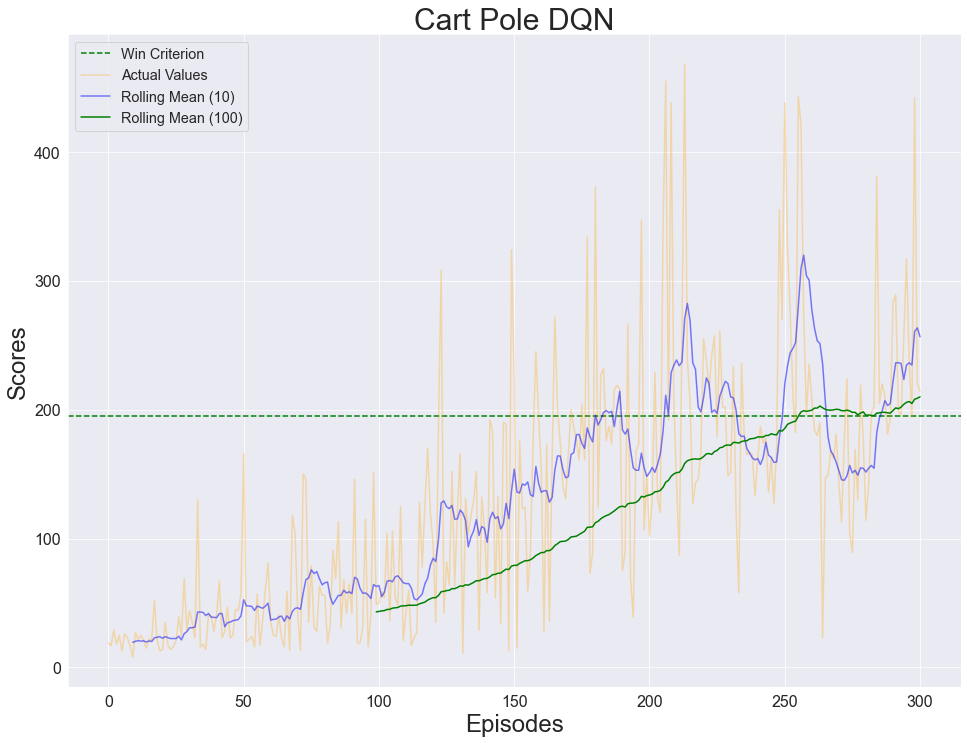

In [14]:
plt.figure(figsize=(16,12))
plt.axhline(195, color='green', linestyle='--', label='Win Criterion') # this is our win condition
plt.plot(df, alpha=.3, label='Actual Values', color='orange') # each episode's score
plt.plot(df.rolling(10).mean(), alpha=.5, label='Rolling Mean (10)', color='blue') # rolling 10 mean
plt.plot(df.rolling(100).mean(), label='Rolling Mean (100)', color='green') # rolling 100 mean, this is
                                                                            # how we tell if we've solved
plt.legend(fontsize='x-large')
plt.xlabel('Episodes', fontsize=24)
plt.xticks(fontsize=16)
plt.ylabel('Scores', fontsize=24)
plt.yticks(fontsize=16)
plt.title('Cart Pole DQN', fontsize=30);

In the above graph (which is different from the one in the slides, as I re-ran this notebook), the agent reaches the solved criterion at about 250 episodes, but the first episode that passed 200 was about half that, at about episode 125